In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!kaggle datasets download -d helviz/undersample-majority

! unzip "undersample-majority.zip"



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

In [5]:
# Directories for training, validation, and testing
train_dir = "/content/undersample_split/1.train"
val_dir = "/content/undersample_split/2.val"
test_dir = "/content/undersample_split/3.test"

# Image Parameters
IMG_SIZE = 224
BATCH_SIZE = 32

# Data Augmentation & Preprocessing
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load Swin Transformer Model
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=len(train_dataset.classes))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training the Model
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    start_time = time.time()
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")
    training_time = time.time() - start_time
    return training_time

training_time = train_model(model, train_loader, val_loader, criterion, optimizer)

# Evaluating the Model
def evaluate_model(model, val_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

y_true, y_pred = evaluate_model(model, val_loader)
class_labels = train_dataset.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Epoch 1, Loss: 1.5079
Epoch 2, Loss: 0.8041
Epoch 3, Loss: 0.5768
Epoch 4, Loss: 0.4229
Epoch 5, Loss: 0.3174
Epoch 6, Loss: 0.2062
Epoch 7, Loss: 0.2042
Epoch 8, Loss: 0.1651
Epoch 9, Loss: 0.1113
Epoch 10, Loss: 0.0797
Classification Report:
                         precision    recall  f1-score   support

         1. No DR signs       0.86      0.80      0.83        15
2. Mild (or early) NPDR       1.00      1.00      1.00        15
       3. Moderate NPDR       1.00      0.25      0.40        12
         4. Severe NPDR       0.64      0.93      0.76        15
    5. Very Severe NPDR       0.71      0.80      0.75        15
                 6. PDR       0.50      0.62      0.55        13
        7. Advanced PDR       0.92      0.80      0.86        15

               accuracy                           0.76       100
              macro avg       0.80      0.74      0.73       100
           weighted avg       0.80      0.76      0.75       100



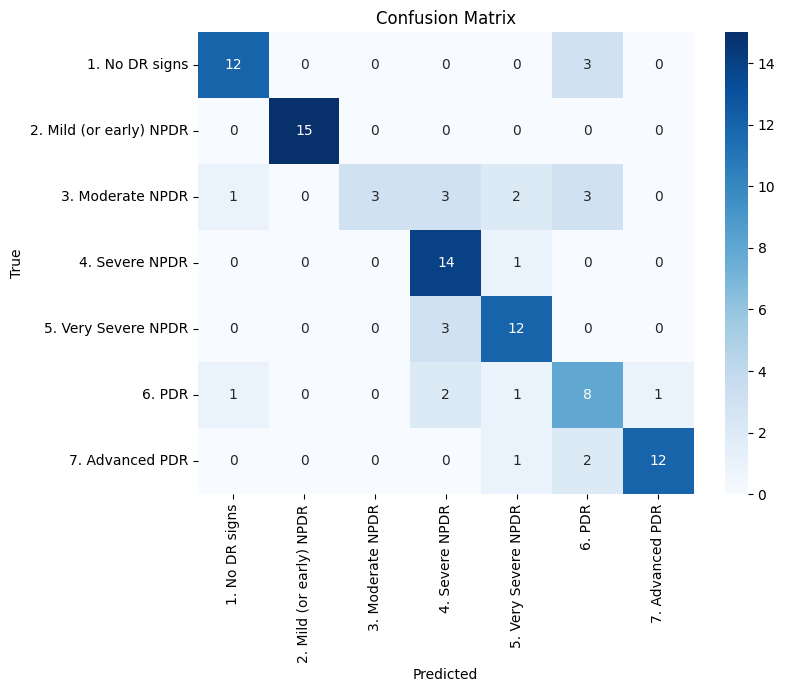

Training Time: 3393.39 seconds
Accuracy: 0.7600
Precision: 0.8032
Recall (Sensitivity): 0.7427
F1-Score: 0.7347
Specificity: 0.9469


In [6]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Compute Metrics
TN = np.diag(cm).sum() - cm.sum(axis=0)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)
accuracy = np.trace(cm) / np.sum(cm)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {np.mean(precision):.4f}")
print(f"Recall (Sensitivity): {np.mean(recall):.4f}")
print(f"F1-Score: {np.mean(f1_score):.4f}")
print(f"Specificity: {np.mean(specificity):.4f}")